Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Wrangle ML datasets

- [x] Continue to clean and explore your data. 
- [x] For the evaluation metric you chose, what score would you get just by guessing?
- [x] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

In [1]:
# I'm running this locally, files stored here
%cd LoL_project

C:\Users\thedo\LoL_project


In [2]:
# Using my dataset, already split into train and test yesterday

# I plan to use cross-validation in my final model, 
# so for now I will combine train and val
import pandas as pd
train = pd.read_csv('LoL_train_cleaned.csv', index_col=0).append(
        pd.read_csv('LoL_val_cleaned.csv', index_col=0))

print(train.shape)
train.head()

(43766, 61)


,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
22656,3214824413,0,1274,9,2,2,2,2,0,2,...,10,2,0,2,1,Katarina,Yasuo,Lucian,Zac,Darius
17347,3214843995,2392998,2033,9,1,2,1,1,2,1,...,6,0,1,3,1,Zac,Camille,Galio,Draven,Xayah
9978,3214825708,3633614,2087,9,1,2,2,1,1,2,...,4,0,0,2,1,Vladimir,Ivern,Galio,Fizz,Fiora
34410,3214844763,4917497,2323,9,1,1,2,1,2,2,...,3,0,1,2,0,Zac,Fiora,Yasuo,Lulu,Fizz
10658,3214864950,6643444,1613,9,2,1,1,2,2,1,...,6,1,1,1,0,Zyra,Kassadin,Xayah,Katarina,Ivern


## Continue to clean and explore your data

In [0]:
# Pandas profile
from pandas_profiling import ProfileReport

# Get the profile
profile = ProfileReport(train, minimal=True)

# Save the report as an html file, so I can read it later and on another tab
profile.to_file('LoL_profile.html')

# Display the profile inide this notebook
#profile.to_notebook_iframe()

Yesterday I did some basic exploration, but now I have the data split so I won't be viewing anything from the test data.  Let's look at how some of these features relate to the target 'winner'.

In [0]:
# Split data on which team won
wins1 = train[train['winner'] == 1]
wins2 = train[train['winner'] == 2]

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

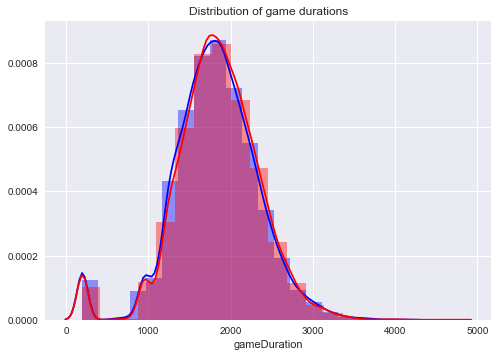

In [18]:
# Teams in League are colored blue and red.  I can only assume which is 1 or 2,
# but it does give me a handy convention for coloring graphs

# I already know wins are split almost 50/50.  gameDuration is also split evenly
sns.distplot(wins1['gameDuration'], bins=20, color='blue')
sns.distplot(wins2['gameDuration'], bins=20, color='red')
plt.title('Distribution of game durations');

While this distribution is about even, it does actually reveal something I need to consider.  There is a number of games with short durations, maybe even 0.  The majority of these games take half an hour, so how are people winning so fast?  I believe they may be forfeits.  

With that in mind, I will probably want to drop those rows before training my model since the champions picked have no effect on which team wins when one side just gives up immediately.

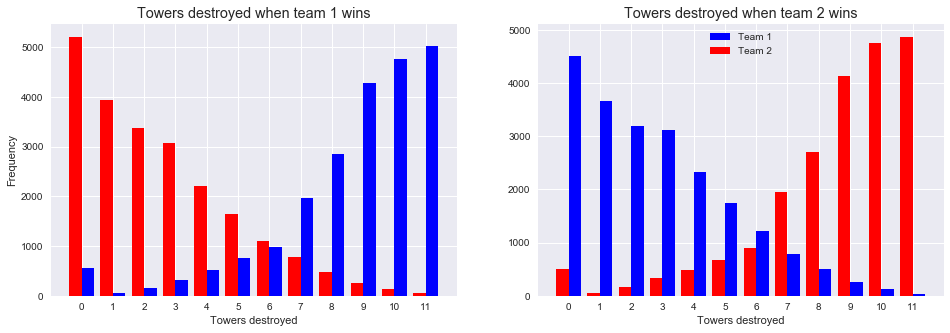

In [121]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16,5)

ax[0].set_title('Towers destroyed when team 1 wins', fontsize='x-large')
kills = wins1['t1_towerKills'].value_counts()
p1 = ax[0].bar(x=kills.index+.2, height=kills, width=.4, color='b')
kills = wins1['t2_towerKills'].value_counts()
p2 = ax[0].bar(x=kills.index-.2, height=kills, width=.4, color='r')
ax[0].set_xlabel('Towers destroyed')
ax[0].set_xticks(range(0,12))
ax[0].set_xticklabels(range(0,12))
ax[0].set_ylabel('Frequency')
plt.legend([p1, p2], ['Team 1', 'Team 2'])

ax[1].set_title('Towers destroyed when team 2 wins', fontsize='x-large')
kills = wins2['t1_towerKills'].value_counts()
ax[1].bar(x=kills.index+.2, height=kills, width=.4, color='b')
kills = wins2['t2_towerKills'].value_counts()
ax[1].bar(x=kills.index-.2, height=kills, width=.4, color='r')
ax[1].set_xlabel('Towers destroyed')
ax[1].set_xticks(range(0,12))
ax[1].set_xticklabels(range(0,12));

This is something that I didn't consider correctly yesterday.  Before, I put all the columns into a shallow decision tree to try and find a baseline and got 95% accuracy with just the 2 columns used for the graph above.

At first, I interpreted that as "killing towers increases your chance of winning", but that's not entirely true!  It takes a bit of domain knowledge to realize it, but it's extremely difficult to win a game without destroying any towers.  So it's better to say "Teams that win generally destroy more towers".

Now that I've realized this, I can split my data into 2 groups: 
1. pre-game behaviors
  - These columns include which champions and spells were picked or banned before the match started.
  - These are the columns I will use to predict the outcome.
2. in-game behaviors
  - These columns record stats during the game itself, such as number of kills or the game duration.
  - If I'm trying to predict a match outcome ahead of time, I would not have this data.

This still gives me 40 columns of categorical data to predict outcomes with, even before adding some more with feature engineering.

In [127]:
# Speaking of engineering, let's start to put together some of 
# the data I have in mind for that

# I'm going to build a new dataframe, with stats for each champion
# pick rate and win rate are common statistics tracked in League of Legends

pick_cols = columns[columns.str.contains('id')]

# Sum up all the times each champion was picked
champ_counts = train[pick_cols[0]].value_counts()
for i in range(1, len(pick_cols)):
  champ_counts += train[pick_cols[i]].value_counts()

# value_counts keeps the name as the series index
champs = champ_counts.reset_index()
champs.columns = ['name', 'pick_count']

print(champs.shape)
champs.head()

(138, 2)


,name,pick_count
0,Tristana,10982
1,Thresh,11197
2,Vayne,8916
3,Kayn,8204
4,Lee Sin,7929


In [128]:
# Now do the same for the ban counts
ban_cols = columns[columns.str.contains('ban')]

# Sum up all the times each champion was banned
ban_counts = train[ban_cols[0]].value_counts()
for i in range(1, len(ban_cols)):
  ban_counts += train[ban_cols[i]].value_counts()

bans = ban_counts.reset_index()
bans.columns = ['name', 'ban_count']

# Merge to save the new column
champs = pd.merge(champs, bans, on='name')
champs.head()

,name,pick_count,ban_count
0,Tristana,10982,10247
1,Thresh,11197,5014
2,Vayne,8916,7410
3,Kayn,8204,14601
4,Lee Sin,7929,5570


In [129]:
# How often was each champion picked or banned?
# Divide the counts by total number of matches to get that
champs['pick_rate'] = champs['pick_count'] / len(train)
champs['ban_rate'] = champs['ban_count'] / len(train)
champs.head()

,name,pick_count,ban_count,pick_rate,ban_rate
0,Tristana,10982,10247,0.250925,0.234132
1,Thresh,11197,5014,0.255838,0.114564
2,Vayne,8916,7410,0.203720,0.169310
3,Kayn,8204,14601,0.187451,0.333615
4,Lee Sin,7929,5570,0.181168,0.127268


In [130]:
# Now let's calculate win rate.  When a champ is picked how often does it win?

# picks when team 1 wins
t1_cols = pick_cols[:5]
win_counts = wins1[t1_cols[0]].value_counts()
for i in range(1, len(t1_cols)):
  win_counts += wins1[t1_cols[i]].value_counts()

# picks when team 2 wins
t2_cols = pick_cols[5:]
for i in range(len(t2_cols)):
  win_counts += wins2[t2_cols[i]].value_counts()

# It happens to use t1_champ1id because that was the first column added up
win_counts.reset_index().head()

,index,t1_champ1id
0,Tristana,5656
1,Thresh,5295
2,Vayne,4588
3,Kayn,3987
4,Janna,4170


In [131]:
# divide wins by total picks and save the percentage
champs['win_rate'] = (win_counts.reset_index()['t1_champ1id'] / 
                                                champs['pick_count'])
champs.head()

,name,pick_count,ban_count,pick_rate,ban_rate,win_rate
0,Tristana,10982,10247,0.250925,0.234132,0.515025
1,Thresh,11197,5014,0.255838,0.114564,0.472895
2,Vayne,8916,7410,0.203720,0.169310,0.514581
3,Kayn,8204,14601,0.187451,0.333615,0.485982
4,Lee Sin,7929,5570,0.181168,0.127268,0.525918


In [139]:
# Wins aren't the only stat tracked in this data

# For example, there are neutral monsters that players can hunt down.  They are 
# awarded with buffs that help beat the other team if they kill them.

# The two biggest are dragon and baron, and I have columns for each

# Example: when player 1 picks a certain champion, how many times on average 
# does team 1 kill those monsters on average?
train.groupby('t1_champ1id').mean()[['t1_baronKills', 't1_dragonKills']].head()

,t1_baronKills,t1_dragonKills
t1_champ1id,,
Aatrox,0.325581,1.313953
Ahri,0.402357,1.430976
Akali,0.359504,1.566116
Alistar,0.306569,1.244526
Amumu,0.331395,1.366279


In [231]:
# initialize the columns with any float value
champs['dragon_kill_rate'] = [.5] * len(champs)
champs['baron_kill_rate'] = [.5] * len(champs)

for i in champs.index:
  champ = champs.loc[i,'name']

  # Get a mask for each game team 1 used this champ
  team_mask = (train[['t1_champ1id', 't1_champ2id', 't1_champ3id', 
                  't1_champ4id', 't1_champ5id']] == champ).any(axis='columns')
  # Add together all team 1 kills
  dragons = train[team_mask]['t1_dragonKills'].sum()
  barons = train[team_mask]['t1_baronKills'].sum()

  # Do the same for team 2
  team_mask = (train[['t2_champ1id', 't2_champ2id', 't2_champ3id', 
                  't2_champ4id', 't2_champ5id']] == champ).any(axis='columns')
  dragons += train[team_mask]['t2_dragonKills'].sum()
  barons += train[team_mask]['t2_baronKills'].sum()
  
  # divide counts by total pick count to get averages
  champs.at[i,'dragon_kill_rate'] = dragons / champs.loc[i,'pick_count']
  champs.at[i,'baron_kill_rate'] = barons / champs.loc[i,'pick_count']

champs.head()

,name,pick_count,ban_count,pick_rate,ban_rate,win_rate,dragon_kill_rate,baron_kill_rate
0,Tristana,10982,10247,0.250925,0.234132,0.515025,1.398106,0.410126
1,Thresh,11197,5014,0.255838,0.114564,0.472895,1.401000,0.398857
2,Vayne,8916,7410,0.203720,0.169310,0.514581,1.369897,0.407470
3,Kayn,8204,14601,0.187451,0.333615,0.485982,1.281326,0.352511
4,Lee Sin,7929,5570,0.181168,0.127268,0.525918,1.460840,0.391222


In [236]:
champs.describe()

,pick_count,ban_count,pick_rate,ban_rate,win_rate,dragon_kill_rate,baron_kill_rate
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,3171.449275,3148.688406,0.072464,0.071944,0.502039,1.400488,0.393037
std,2080.029653,5068.235230,0.047526,0.115803,0.068461,0.094030,0.030171
min,479.000000,59.000000,0.010945,0.001348,0.266892,1.099099,0.314189
25%,1599.500000,351.750000,0.036547,0.008037,0.461697,1.354413,0.374607
50%,2678.000000,1101.500000,0.061189,0.025168,0.503303,1.396106,0.390714
75%,4091.250000,3762.750000,0.093480,0.085974,0.542023,1.446050,0.409615
max,11197.000000,28367.000000,0.255838,0.648152,0.762004,1.931101,0.502172


### To stay organized, here is a data dictionary for this new dataframe

name - the name of the champion

pick_count - number of times this champion was picked in a game

ban_count - number of times this champion was banned in a game

pick_rate - percentage of all games where this champion is picked

ban_rate - percentage of all games where this champion is banned

win_rate - how often this champion's team wins when it is picked

dragon_kill_rate - the average number of times this champion's team kills the dragon

baron_kill_rate - the average number of times this champion's team kills the baron

In [0]:
# Let's save that so I can use it later without re-running all the calculations
champs.to_csv('champ_stats.csv')

I can do a few visualizations with this data too.  I already did bar graphs of the pick and ban counts yesterday.

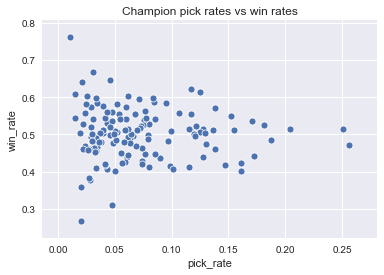

In [133]:
# Are champions who win more often more popular (picked more often)?
sns.scatterplot(x=champs['pick_rate'], y=champs['win_rate'])
plt.title('Champion pick rates vs win rates');

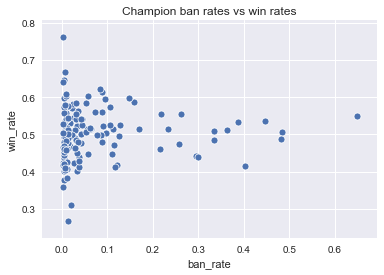

In [125]:
# What about bans?
sns.scatterplot(x=champs['ban_rate'], y=champs['win_rate'])
plt.title('Champion ban rates vs win rates');

To be fair, in a well-balanced game each champion should have similar win rates.  League is continually re-balanced, and is a fair enough game to have international tournaments with huge prize pools.  

In fact, the official world championship awards \$1-$2.5 million to the winning team alone!

https://en.wikipedia.org/wiki/League_of_Legends_World_Championship

It's popularity is even on par with the Super Bowl 

https://www.cnbc.com/2019/04/14/league-of-legends-gets-more-viewers-than-super-bowlwhats-coming-next.html

The game designers know what they are doing.

## For the evaluation metric you chose, what score would you get just by guessing?

In [18]:
# I would be 50% accurate just by guessing
train['winner'].value_counts(normalize=True)

1    0.50866
2    0.49134
Name: winner, dtype: float64

## Can you make a fast, first model that beats guessing?

In [63]:
# For the baseline, just do a standard split
from sklearn.model_selection import train_test_split
split_train, split_val = train_test_split(train, test_size=.2)

split_train.shape, split_val.shape

((35012, 61), (8754, 61))

In [0]:
# picking features - as mentioned above I can only use certain ones
columns = train.columns
champs_used = columns[columns.str.contains('id')]     # 10 columns
champs_banned = columns[columns.str.contains('ban')]  # 10 columns
spells_used = columns[columns.str.contains('sum')]    # 20 columns

In [64]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

# Using all 40 pre-game behavior columns
target = 'winner'
features = champs_used.append(champs_banned).append(spells_used)
X_train = split_train[features]
y_train = split_train[target]
X_val = split_val[features]
y_val = split_val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=3)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy:', pipeline.score(X_val, y_val))

Validation Accuracy: 0.5102810143934201


My shallow tree beats the baseline by 1%, yay!  It really will be interesting seeing if I can improve that.

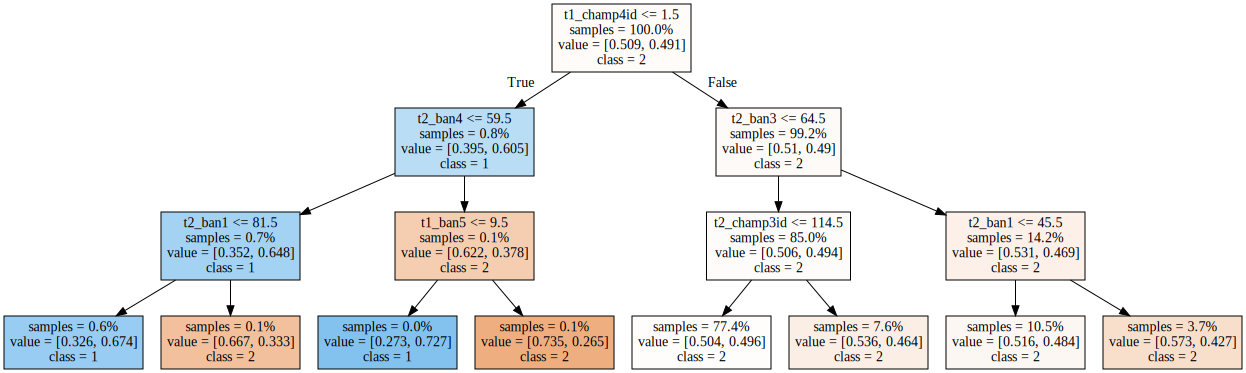

In [67]:
# Visualize that tree
import graphviz
from sklearn.tree import export_graphviz

tree = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree, 
    out_file = None,
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    impurity=False, 
    proportion=True
)

graphviz.Source(dot_data)

Considering the data I have by default is entirely categorical, it will probably be good to research models that can use that without encoding.  Or just find other encoding methods.

## Get started on feature engineering

In [240]:
# To make things easier, I'll make it so I can use the name as the index
champs.index = champs['name']
champs = champs.drop(columns='name')
champs.head()

,pick_count,ban_count,pick_rate,ban_rate,win_rate,dragon_kill_rate,baron_kill_rate
name,,,,,,,
Tristana,10982,10247,0.250925,0.234132,0.515025,1.398106,0.410126
Thresh,11197,5014,0.255838,0.114564,0.472895,1.401000,0.398857
Vayne,8916,7410,0.203720,0.169310,0.514581,1.369897,0.407470
Kayn,8204,14601,0.187451,0.333615,0.485982,1.281326,0.352511
Lee Sin,7929,5570,0.181168,0.127268,0.525918,1.460840,0.391222


In [241]:
champs.loc['Ashe']

pick_count          4654.000000
ban_count            427.000000
pick_rate              0.106338
ban_rate               0.009756
win_rate               0.557800
dragon_kill_rate       1.365062
baron_kill_rate        0.380963
Name: Ashe, dtype: float64

In [0]:
# Since this has to calculate some things by individual rows, 
# it will take a bit to run

def engineer_features(X):
  """ returns X with new engineered features """
  X = X.copy()

  # calculate 4 new columns for each row:
  new_col = [.0] * len(X) # initialize with floats

  # average win rate for champs on each team (mean of win rates)
  X['t1_win_rate'] = new_col
  X['t2_win_rate'] = new_col
  # average ban rate for champs on each team 
  # (this is particularly interesting, since it tells how often 
  # the champs picked in this game were banned in others)
  X['t1_ban_rate'] = new_col
  X['t2_ban_rate'] = new_col

  for i in X.index:
    # extract team lists
    team1 = X.loc[i][['t1_champ1id', 't1_champ2id', 't1_champ3id', 
                      't1_champ4id', 't1_champ5id']]
    team2 = X.loc[i][['t2_champ1id', 't2_champ2id', 't2_champ3id', 
                      't2_champ4id', 't2_champ5id']]

    # average stats
    t1_stats = champs.loc[team1].mean()
    X.at[i, 't1_win_rate'] = t1_stats['win_rate']
    X.at[i, 't1_ban_rate'] = t1_stats['ban_rate']

    t2_stats = champs.loc[team2].mean()
    X.at[i, 't2_win_rate'] = t2_stats['win_rate']
    X.at[i, 't2_ban_rate'] = t2_stats['ban_rate']

  # Also find the difference between those average rates
  X['win_rate_diff'] = X['t1_win_rate'] - X['t2_win_rate']
  X['ban_rate_diff'] = X['t1_ban_rate'] - X['t2_ban_rate']

  return X

In [277]:
%%time
train = engineer_features(train)

Wall time: 2min 6s


In [263]:
# view the new columns
train[train.columns[-6:]].head()

,t1_win_rate,t2_win_rate,t1_ban_rate,t2_ban_rate,win_rate_diff,ban_rate_diff
22656,0.517458,0.444778,0.191523,0.058082,0.072680,0.133441
17347,0.500740,0.507390,0.105721,0.016739,-0.006650,0.088982
9978,0.513434,0.515845,0.020477,0.134095,-0.002411,-0.113618
34410,0.477560,0.469466,0.105858,0.038962,0.008094,0.066897
10658,0.480455,0.528259,0.308034,0.118540,-0.047804,0.189494


So I now have a numerical representation of each team, based on statistics of the champions picked.  Let's explore and see if this was worth it.

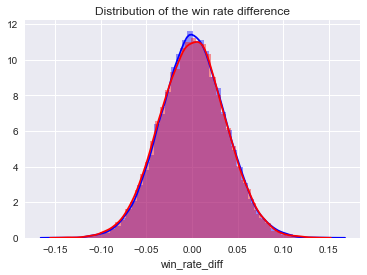

In [265]:
# split by the target again, so we can check distribution between the outcomes
wins1 = train[train['winner'] == 1]
wins2 = train[train['winner'] == 2]

sns.distplot(wins1['win_rate_diff'], color='b')
sns.distplot(wins2['win_rate_diff'], color='r')
plt.title('Distribution of the win rate difference');

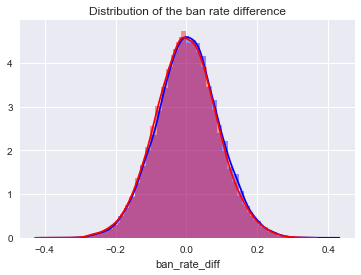

In [266]:
sns.distplot(wins1['ban_rate_diff'], color='b')
sns.distplot(wins2['ban_rate_diff'], color='r')
plt.title('Distribution of the ban rate difference');

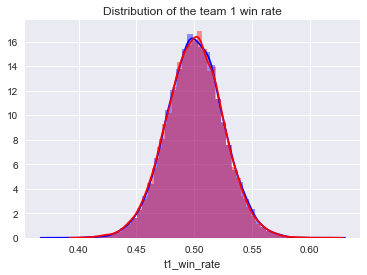

In [267]:
sns.distplot(wins1['t1_win_rate'], color='b')
sns.distplot(wins2['t1_win_rate'], color='r')
plt.title('Distribution of the team 1 win rate');

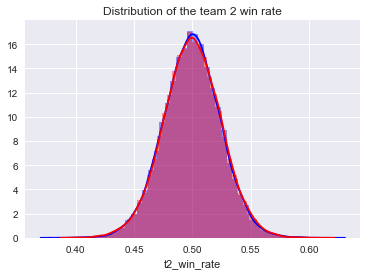

In [268]:
sns.distplot(wins1['t2_win_rate'], color='b')
sns.distplot(wins2['t2_win_rate'], color='r')
plt.title('Distribution of the team 2 win rate');

The distributions don't exactly look like they'll help tell the difference, but let's try some quick models just to see.

In [269]:
# split the data again
split_train, split_val = train_test_split(train, test_size=.2)

split_train.shape, split_val.shape

((35012, 67), (8754, 67))

In [274]:
# Using just the new engineered columns
target = 'winner'
features = train.columns[-6:]
X_train = split_train[features]
y_train = split_train[target]
X_val = split_val[features]
y_val = split_val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=3)
)

pipeline.fit(X_train, y_train)
print('Shallow decision tree accuracy:', pipeline.score(X_val, y_val))

Shallow decision tree accuracy: 0.512794151245145


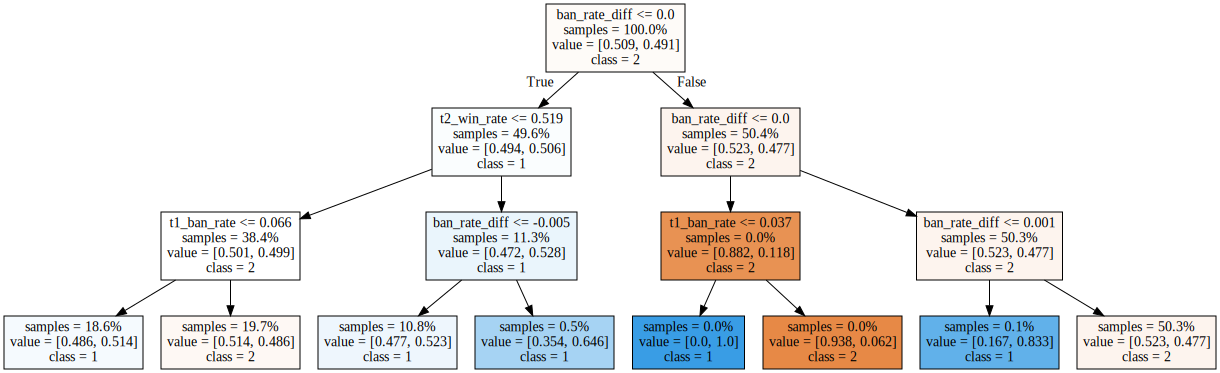

In [275]:
tree = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree, 
    out_file = None,
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    impurity=False, 
    proportion=True
)

graphviz.Source(dot_data)

In [276]:
# Same but with logistic regression instead
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    LogisticRegression()
)

pipeline.fit(X_train, y_train)
print('Logistic regression accuracy:', pipeline.score(X_val, y_val))

Logistic regression accuracy: 0.5087959789810372


Well now I'm a bit worried, I had really hoped that finding and using statistics from each champion would at least make some difference, but I'm still just tossing a coin here.  But I still have a lot of things to try, such as other encoding methods, other models, and other feature engineering.  To be continued...